# Stationary Equilibrium

**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
- 2. [Solve household problem](#toc2_)    
- 3. [Find stationary equilibrium](#toc3_)    
  - 3.1. [Direct approach](#toc3_1_)    
  - 3.2. [Indirect approach](#toc3_2_)    
  - 3.3. [Finding beta approach](#toc3_3_)    
  - 3.4. [Looking at the stationary equilibrium](#toc3_4_)    
    - 3.4.1. [Policy functions](#toc3_4_1_)    
    - 3.4.2. [Distributions](#toc3_4_2_)    
- 4. [Aggregate savings and the interest rate](#toc4_)    
- 5. [Idiosyncratic risk and the steady state interest rate](#toc5_)    
- 6. [Calibration](#toc6_)    
- 7. [Extra: Demand vs. supply of capital](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

**Contents:**

1. Introduces the `GEModelTools`
1. Solves and simulates a simple **Heterogenous Agent Neo-Classical (HANC) model**

In [2]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

from HANCModel import HANCModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
model = HANCModelClass(name='baseline') # create an instance of the model

In [7]:
# compute the steady-state with the beta method
# Code HERE
model.find_ss(method='beta', beta_min=0.5)
print(model.par.beta_mean)

0.8860869652226033


In [9]:
model.ss.clearing_A

1.1233680652367184e-11

In [10]:
model.ss.clearing_Y

1.3815783961312889e-08

In [11]:
model.par.beta_mean

0.8860869652226033

- We want a K/Y = 4 at the annual frequency
- We solve the model at the *quaterly* frequency
- We normalyze quaterly output $Y=1$
- So $K/Y=16$

In [17]:
model.ss.K

16.0

In [18]:
model.ss.Y

1.0

In [8]:
model.info(ss=True)

settings:
 par.py_hh = True
 par.py_blocks = True
 par.full_z_trans = False
 par.warnings = True
 par.T = 500

households:
 grids_hh: [a]
 pols_hh: [a]
 inputs_hh: [r,w]
 inputs_hh_z: []
 outputs_hh: [a,c]
 intertemps_hh: [vbeg_a]

aggregate:
 shocks: []
 unknowns: []
 targets: []

blocks (inputs -> outputs):
 production_firm: [] -> [Gamma=0.40,K=16.00,L=1.00,rK=0.02,w=0.67,Y=1.00]
 mutual_fund: [K=16.00,rK=0.02] -> [A=16.00,r=0.01]
 hh: [r=0.01,w=0.67] -> [A_hh=16.00,C_hh=0.87]
 market_clearing: [A=16.00,A_hh=16.00,L=1.00,Y=1.00,C_hh=0.87,K=16.00] -> [L_hh=nan,I=0.13,clearing_A=0.00,clearing_L=nan,clearing_Y=0.00]


**MPC:**

In [12]:
def calc_MPC(par,ss):
    
    MPC = np.zeros(ss.D.shape)
    dc = (ss.c[:,:,1:]-ss.c[:,:,:-1])
    dm = (1+model.ss.r)*par.a_grid[np.newaxis,np.newaxis,1:]-(1+model.ss.r)*par.a_grid[np.newaxis,np.newaxis,:-1]
    MPC[:,:,:-1] = dc/dm
    MPC[:,:,-1] = MPC[:,:,-1] # assuming constant MPC at end
    
    return MPC

MPC = calc_MPC(model.par,model.ss)

mean_MPC = np.sum(MPC*model.ss.D)
print(f'mean MPC: {mean_MPC:.3f}')

mean MPC: 0.442


In [16]:
MPC.shape

(3, 7, 500)

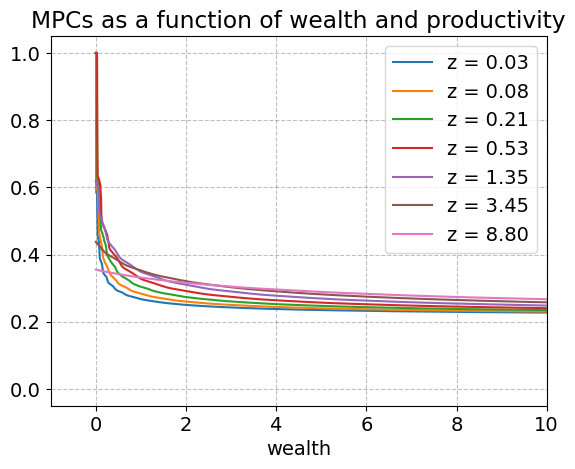

In [15]:
plt.plot(model.par.a_grid, MPC[0].T)
plt.xlim(-1, 10)
plt.legend([f'z = {z:.2f}' for z in model.par.z_grid])
plt.title('MPCs as a function of wealth and productivity')
plt.xlabel('wealth')
plt.show()

In [19]:
def calib_obj(beta_delta,model):
    """ calibration objective """
    
    #fill things up here: update beta_delta and compute ss 
    model.par.beta_delta = beta_delta # update our parameter
    # Solve the model (at the stedy state)
    model.find_ss(method = 'beta', beta_min = 0.5, beta_max = 0.98, do_print=False)
    MPC = calc_MPC(model.par,model.ss)
    mean_MPC = np.sum(MPC*model.ss.D)
    print(f'beta_delta: {beta_delta:.4f} => mean_MPC: {mean_MPC:.4f}')
    
    return mean_MPC-0.27

In [20]:
from root_finding import brentq
model_calib = model.copy()
brentq(calib_obj,0.01,0.1,args=(model_calib,),do_print=True,varname='beta_delta',funcname='MPC-0.27',xtol=1e-8,rtol=1e-8);

beta_delta: 0.0100 => mean_MPC: 0.0701


/Users/raphaelhuleux/Documents/_projects/AdvMacroHet/03-04-Stationary-Equilibrium/1_HANC-beta-heterogeneity/household_problem.py:26: RuntimeWarning: divide by zero encountered in reciprocal
  v_a = (1+r)*c[i_fix]**(-par.sigma)


beta_delta: 0.1000 => mean_MPC: 0.4417
beta_delta: 0.0584 => mean_MPC: 0.2867
  0: beta_delta =   0.05841611 -> MPC-0.27 =   0.01670839
beta_delta: 0.0543 => mean_MPC: 0.2704
  1: beta_delta =   0.05427864 -> MPC-0.27 =   0.00039874
beta_delta: 0.0542 => mean_MPC: 0.2700
  2: beta_delta =   0.05417849 -> MPC-0.27 =  -0.00003693
beta_delta: 0.0542 => mean_MPC: 0.2700
  3: beta_delta =   0.05418698 -> MPC-0.27 =   0.00000010
beta_delta: 0.0542 => mean_MPC: 0.2700
  4: beta_delta =   0.05418696 -> MPC-0.27 =   0.00000000
beta_delta: 0.0542 => mean_MPC: 0.2700
  5: beta_delta =   0.05418695 -> MPC-0.27 =  -0.00000002

beta_delta =   0.05418696 [MPC-0.27 =   0.00000000]

beta_delta: 0.0542 => mean_MPC: 0.2700


In [21]:
print(f'ss.r = {model_calib.ss.r*100:.2f} %')
print(f'ss.K = {model_calib.ss.K:.2f}')
print(f'K/Y = {(model_calib.ss.K / model_calib.ss.Y):.2f}')

ss.r = 1.25 %
ss.K = 16.00
K/Y = 16.00


Now, compute the distribution of wealth and compare it to the data, as in the previous notebook. How did the distribution of wealth change?

In [23]:
# a. prepare
ss = model_calib.ss
par = model_calib.par
Da = np.sum(ss.D,axis=(0,1))


def get_share(D=None, a_grid=None, perc_bottom=0.0, perc_top=1.0):

    cdf = D.cumsum()
    wealth_cdf = (a_grid * D).cumsum()
    tot_wealth = (a_grid * D).sum()

    if perc_bottom == 0.0:
        wealth_bottom = 0.0
    else:
        wealth_bottom = np.interp(perc_bottom, cdf, wealth_cdf)

    if perc_top == 1.0:
        wealth_top = tot_wealth         
    else:
        wealth_top = np.interp(perc_top, cdf, wealth_cdf)
    
    wealth = wealth_top - wealth_bottom
    share = wealth / tot_wealth

    return share

b50 = get_share(D=Da, a_grid=par.a_grid, perc_bottom=0.0, perc_top=0.5) 
n40 = get_share(D=Da, a_grid=par.a_grid, perc_bottom=0.5, perc_top=0.9)
top10 = get_share(D=Da, a_grid=par.a_grid, perc_bottom=0.9, perc_top=1.0)
top100 = get_share(D=Da, a_grid=par.a_grid, perc_bottom=0.99, perc_top=1.0)
top1000 = get_share(D=Da, a_grid=par.a_grid, perc_bottom=0.999, perc_top=1.0)
top10000 = get_share(D=Da, a_grid=par.a_grid, perc_bottom=0.9999, perc_top=1.0)

wealth_shares = np.array([b50, n40, top10, top100, top1000, top10000]) * 100


# Code here
import pandas as pd
df = pd.read_csv(
    '../wealth_psz.csv')
df = df[df['Year'] == 2019]

# Round 'value' column, convert to integer and drop 'Year' column

df['value'] = df['value'] * 100
df = df.drop(columns='Year')

# Add 'Model' column with wealth shares, round and convert to integer
df['Model'] = wealth_shares

# Rename 'value' column to 'Data PSZ'
df = df.rename(columns={'value': 'Data PSZ'})

# Pivot the DataFrame and reorder columns
df = pd.pivot_table(df, columns='Quantile', values=['Data PSZ', 'Model'])
df = df[['Bottom 50%', 'Middle 40%', 'Top 10%',
            'Top 1%', 'Top 0.1%', 'Top 0.01%']]

print(df.round(0))


Quantile  Bottom 50%  Middle 40%  Top 10%  Top 1%  Top 0.1%  Top 0.01%
Data PSZ         0.0        28.0     71.0    35.0      18.0        9.0
Model            1.0        42.0     57.0    10.0       1.0        0.0


In [24]:
ss.K / ss.Y

16.0